In [2]:
import pandas as pd
import numpy as np
from gurobipy import *
from datetime import datetime

# Erste Schritte: Data Handling
<font size="4">Lest die Datei "2020_Last_DE.csv" als Pandas-dataframe ein und lasst euch die ersten 5 Zeilen anzeigen. </font>

**Hinweis** Dateipfade müssen relativ zum verzeichnis des Jupyter Notebooks angegeben werden.

In [2]:
df = pd.read_csv("Data/2020_Last_DE.csv")

In [3]:
df.head()

,Datum;Uhrzeit;Gesamt (Netzlast)[MWh];Residuallast[MWh];Pumpspeicher[MWh]
0,01.01.2020;00:00;10.899;9.302;49
1,01.01.2020;00:15;10.837;9.241;66
2,01.01.2020;00:30;10.759;9.099;97
3,01.01.2020;00:45;10.719;8.999;129
4,01.01.2020;01:00;10.678;8.942;235


In [4]:
df = pd.read_csv("Data/2020_Last_DE.csv", sep = ";")

<font size="4">Erstellt eine neue Spalte mit dem Titel **"Zeitschritt"**, die sich aus den Spalten **"Datum"** und **"Uhrzeit"** zusammensetzt.<font>

In [5]:
df["Zeitschritt"] = df.apply(lambda row: row["Datum"] + " " + row["Uhrzeit"], axis = 1)
df["Zeitschritt alternativ"] = df["Datum"] + " "+  df["Uhrzeit"]

<font size="4">Konvertiert die Spalte Zeitschritt in das **datetime-Format.**<font>

In [6]:
df["Zeitschritt"] = pd.to_datetime(df["Zeitschritt"], format ="%d.%m.%Y %H:%M")

<font size="4">Definiert die Spalte "Zeitschritt" als **Index**.<font>

In [7]:
df.set_index("Zeitschritt", inplace = True)

<font size="4">Lasst euch die Spalte **"Gesamt (Netzlast)[MWh]"** grafisch anzeigen.<font>

<AxesSubplot:xlabel='Zeitschritt'>

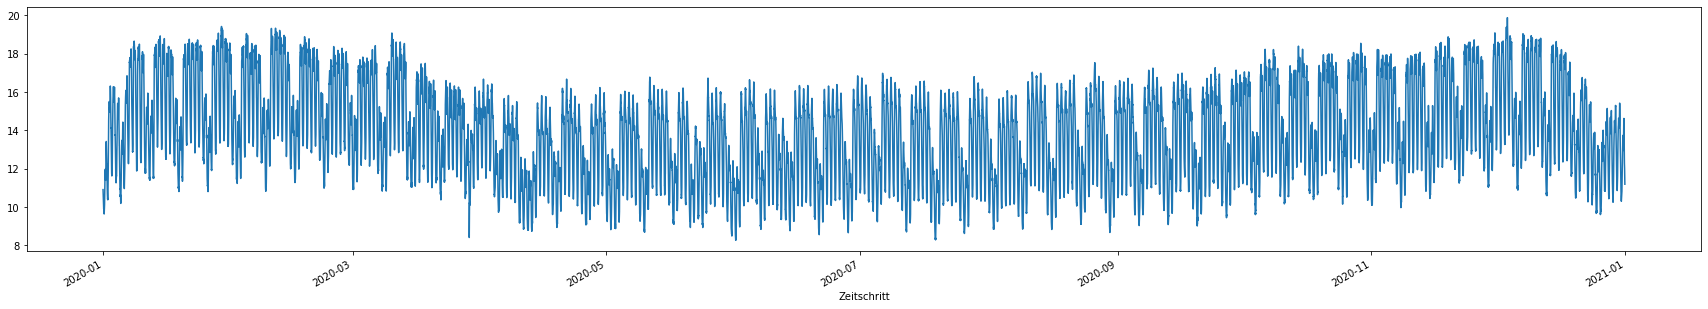

In [8]:
df["Gesamt (Netzlast)[MWh]"].plot(figsize = (30,5))

# Übungsaufgabe: Optimales Demand Side Management

Durch einen sogenannten "Real-Time-Pricing"-Tarif ist es Haushalten möglich, ihre Last in möglichst günstige Stunden zu verschieben. Im Folgenden soll eine optimale Strategie für einen Haushalt bestimmt werden, der möglichst wenig für seinen Stromverbrauch ausgeben möchte. Der Haushalt hat in jedem Zeitschritt einen fixen Lastanteil, den er nicht verschieben kann und einen flexiblen Lastanteil, den er **maximal eine Stunde** nach vorne oder hinten verschieben kann.

## Daten einlesen

Lest die CSV-Datei "SGA_Uebung0_Data.csv" ein und entfernt leere Einträge.

In [3]:
df = pd.read_csv("Data/SGA_Uebung0_Data.csv", sep ="\t") # Hier müsst ihr eventuell die Anweisung hinter "sep" anpassen in ";" oder ","
df.head()

,Datum,Uhrzeit,Last fix [kW],Last flexibel [kW],Tarif [ct/kWh]
0,01.05.2021,00:00,0.0866,0.00866,32
1,01.05.2021,01:00,0.1588,0.01588,32
2,01.05.2021,02:00,0.1366,0.01366,32
3,01.05.2021,03:00,0.1293,0.01293,32
4,01.05.2021,04:00,0.1304,0.01304,31


In [4]:
df.dropna(axis = 0, inplace = True) # Konvention: axis = 0 für Beseitigung von Zeilen, axis = 1 für Spalten

In [5]:
df

,Datum,Uhrzeit,Last fix [kW],Last flexibel [kW],Tarif [ct/kWh]
0,01.05.2021,00:00,0.0866,0.00866,32
1,01.05.2021,01:00,0.1588,0.01588,32
2,01.05.2021,02:00,0.1366,0.01366,32
3,01.05.2021,03:00,0.1293,0.01293,32
4,01.05.2021,04:00,0.1304,0.01304,31
5,01.05.2021,05:00,0.1401,0.01401,31
6,01.05.2021,06:00,0.2208,0.02208,29
7,01.05.2021,07:00,0.3627,0.10881,28
8,01.05.2021,08:00,0.4106,0.08212,27
9,01.05.2021,09:00,0.4106,0.16424,25


## Daten für Optimierung vorbereiten

Die Spalten unserer Inputdatei, die wir für die Modellierung des Optimierungsproblems benötigen, müssen zu Listen konvertiert werden. Dafür gibt es verschiedene Ansätze.

1. type casting

In [6]:
last_fix = df["Last fix [kW]"].to_list()

2. List comprehension

In [7]:
last_flex = [i for i in df["Last flexibel [kW]"]]

3. Spalte über Index anstatt Namen referenzieren

In [8]:
rtp = df[df.columns[4]].to_list()

In [9]:
n_timesteps = len(df) # die Funktion len() gibt die Länge des DataFrames zurück, also die Anzahl an Zeilen

# range(24) bezeichnet das Intervall von 0 bis 23. Python fängt default-mäßig an bei 0 zu zählen und endet bei n-1
## range(2,30) wäre das Intervall von 2 bis 29

Bestimmt mithilfe einer Optimierung, wie der Haushalt seine Last optimal verschieben kann. **Tipp**: Schreibt euch das Optimierungsproblem zuerst formal auf einem Blatt Papier auf.

In [11]:
m  = Model("DSM")  #Erstellt eine Instanz eines Gurobi-Gptimierungsmodells
m.setParam("OutputFlag",0)  #Kann auch deaktiviert werden


# Zuerst müssen alle Entscheidungsvariablen definiert werden 
shift_backwards = m.addVars(range(n_timesteps), vtype = GRB.BINARY, name = "Shift_b")     # hierbei handelt es sich um eine mehrdimensionale Entscheidungsvariable, da wir sie für jeden Zeitschritt bestimmen wollen. Gurobi teilt man das mittels einer range()-Angabe mit
shift_forward = m.addVars(range(n_timesteps), vtype = GRB.BINARY, name = "Shift_f")
no_shift = m.addVars(range(n_timesteps), vtype = GRB.BINARY, name = "no_shift")
last = m.addVars(range(n_timesteps), vtype = GRB.CONTINUOUS, lb = 0, ub = GRB.INFINITY, name = "Last") # lb = lower bound; ub = upper bound
          
#Zielfunktion des Optimierungsproblems
m.setObjective(( quicksum(rtp[t] * last[t]  for t in range(n_timesteps) ) ), GRB.MINIMIZE) #quicksum(... for t in range(start, end))  bildet die Summe über alle variablen von t=0 bis t=23
               
m.addConstrs(( last[t] == (last_fix[t] + no_shift[t]*last_flex[t]+ shift_forward[t-1]* last_flex[t-1] + shift_backwards[t+1]* last_flex[t+1]  )  for t in range(1,n_timesteps-1) ), "Finale Nachfrage in Zeitschritt t") # Diese Nebenbedingung funktioniert nicht im ersten und letzten Zeitschritt, da dann ein Index-Error aufkommen würde (es gibt keinen zeitschritt -1 und 24). Daher starten wir die range bei 1 und iterieren nur bis 22.
m.addConstrs( ((no_shift[t] + shift_forward[t] + shift_backwards[t]) == 1  for t in range(n_timesteps) ), "Shifting flexible Load") # Diese Nebenbedingung gilt für alle Zeitschritte


m.addConstr((last[0] ==   last_fix[0] + no_shift[0]*last_flex[0]+ shift_backwards[1]* last_flex[1]  ) , "Sonderfall erster Zeitschritt")
m.addConstr((last[23] ==   last_fix[23] + no_shift[23]*last_flex[23]+ shift_forward[22]* last_flex[22]  ) , "Sonderfall letzter Zeitschritt")
m.addConstr(shift_backwards[0] == 0)
m.addConstr(shift_forward[23] == 0)


m.optimize() # Hiermit sagen wir explizit, dass jetzt die optimierung des Modells "m" gestartet werden soll
               

Lasst euch die Ergebnisse der Optimierung ausgeben.

In [12]:
v = m.getVars() # Um die Ergebnisse auszulesen muss man immer das Modell "m" aufrufen 


In [13]:
print(v[0].varName)
(v[0].x)

Shift_b[0]


0.0

In [25]:
m.getObjective().getValue()

274.44261000000006

**Tipp: Mit einer Funktion kann man sich die Ergebnisse automatisch in einem schönen Format ausgeben lassen**

In [14]:

def get_results_in_df(variableNames, n_timesteps): #  "def name(argumente)" zeigt den Anfang einer Funktion an, die ich später beliebig aufrufen kann
   

    results_df = pd.DataFrame(columns = variableNames, index = [t for t in range(n_timesteps)] )   # Hier wird ein leeres DataFrame erstellt, dass als Spalteneinträge die Namen der Gutobi-variablen hat und als Zeilen die Zeitschritte der Entscheidungsvariablen

    for n in variableNames:                                         #Iteration über alle Zielvariablen
        for t in range(n_timesteps):                                #Iteration über alle Zeitschritte
            VarName = n + f"[{t}]"                                  #Hier wird ein String erstellt, der die Form n[t] hat. Mit diesem wird später die Zielvariable ausgelesen
            try:                                                    #try - except ist eine hilfreiche Methdoe, um Fehler abzufangen. Wenn in der nächsten Zeile ein error passiert, bspw. wegen eines Schreibfehlers in meinen zielvariablen, wird die Funktion nicht abgebrochen sondern weiter ausgeführt.
                results_df.loc[t][n] = m.getVarByName(VarName).x    #Auslesen der Zielvaribale
            except:
                pass
            
    return results_df                                               #Hier wird festgelegt, was zurückgegeben wird wenn die Funktion aufgerufen wird. In diesem Fall geben wir das fertige DataFrame mit den ergebnissen der Optimierung zurück

In [15]:
# Aufrufen der Funktion

vn = ["Shift_b", "Shift_f", "no_shift", "Last" ] #Hier müssen die Namen meiner Gurobi-Zielvariablen stehen (siehe Optimeirung)
n = n_timesteps
test_results = get_results_in_df(vn, n) # Aufrufen der Funktion und abspeichern meiner Ergebnisse im 

In [16]:
test_results

,Shift_b,Shift_f,no_shift,Last
0,0.0,-0.0,1.0,0.11114
1,1.0,0.0,0.0,0.17246
2,1.0,0.0,0.0,0.1366
3,0.0,1.0,0.0,0.1293
4,0.0,1.0,0.0,0.14333
5,0.0,1.0,0.0,0.15314
6,0.0,1.0,0.0,0.23481
7,0.0,1.0,0.0,0.38478
8,0.0,1.0,0.0,0.51941
9,0.0,1.0,0.0,0.49272


In [18]:
m.getObjective().getValue()

274.44261000000006